# Download and extract data.

In [1]:
#!wget https://www.dropbox.com/s/8cia5dodmhf1do0/UCMerced_LandUse.zip

In [2]:
#!unzip UCMerced_LandUse.zip

In [3]:
# install torchvision 0.3.0 without pytorch 1.1 
import torchvision 

print(torchvision.__version__)

0.3.0


In [4]:
!nvidia-smi

Thu May 30 08:38:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:03:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    582MiB /  4042MiB |     22%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Data exploration

We have 21 different classes. For each class, we have 100 images. All images are RGB and 256x256 pixels.

In [5]:
import os

PATH = './dataset/Images/'
cats = os.listdir(PATH)
cats, len(cats)

(['parkinglot',
  'buildings',
  'tenniscourt',
  'storagetanks',
  'denseresidential',
  'baseballdiamond',
  'agricultural',
  'overpass',
  'sparseresidential',
  'mediumresidential',
  'river',
  'intersection',
  'forest',
  'chaparral',
  'beach',
  'mobilehomepark',
  'freeway',
  'golfcourse',
  'harbor',
  'airplane',
  'runway'],
 21)

In [6]:
#for cat in cats:
#  cnt = !ls {PATH}/{cat} | wc -l 
#  print(cat, cnt)

In [7]:
import pandas as pd

imgs, labs = [], []
for ix, cat in enumerate(cats):
  _imgs = os.listdir(PATH+cat)
  imgs += [cat+'/'+_img for _img in _imgs]
  labs += [ix for _img in _imgs]
df = pd.DataFrame({'img_name': imgs, 'label': labs})
df.sample(5)

,img_name,label
1778,golfcourse/golfcourse84.tif,17
1189,intersection/intersection01.tif,11
704,overpass/overpass09.tif,7
945,mediumresidential/mediumresidential28.tif,9
1064,river/river78.tif,10


In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

ix = random.randint(0, len(df)-1)
img = Image.open(PATH+df.img_name.values[ix])
img = np.array(img)
plt.imshow(img)
img.shape, cats[df.label.values[ix]]

((256, 256, 3), 'storagetanks')

In [9]:
from sklearn.model_selection import train_test_split

df_t, df_v = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df.label)
len(df_t), len(df_v)

(1680, 420)

In [10]:
#df_t.hist(bins=21)
#df_v.hist(bins=21)

# Dataset

We define our dataset so when a new element is requested an image is loaded, resized to 224x224 pixels (input size for Resnet), transposed (Pytorch requires dimensions #channels x height x width), normalized (divide by 255) and transformed to a tensor. 

Then we define our dataloader to load images in batches.

In [11]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, path, imgs, labs):
    self.path = path
    self.imgs = imgs
    self.labs = labs
    
  def __len__(self):
    return len(self.labs)
    
  def __getitem__(self, ix):
    img, lab = self.imgs[ix], self.labs[ix]
    img = Image.open(self.path+self.imgs[ix]).resize((224,224))
    img = np.array(img)
    img = torch.FloatTensor(img.transpose((2,0,1)) / 255)
    return img, lab

In [12]:
dataset = {
    'train': MyDataset(PATH, df_t.img_name.values, df_t.label.values),
    'val': MyDataset(PATH, df_v.img_name.values, df_v.label.values)
}

(torch.Size([3, 224, 224]), 'sparseresidential')

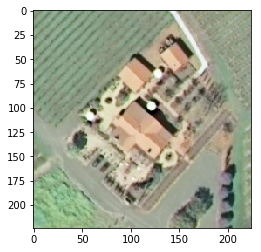

In [13]:
ds = dataset['train']
ix = random.randint(0, len(ds)-1)
img, lab = ds[ix]
plt.imshow(img.numpy().transpose((1,2,0)))
img.shape, cats[lab]

In [14]:
from torch.utils.data import DataLoader

bs = 32
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=bs, num_workers=4, shuffle=True),
    'val': DataLoader(dataset['val'], batch_size=bs, num_workers=4, shuffle=False)
}


# Model

We will use a mobilenet v2 and replace the fully connected layer with a custom head to match our problem.

In [15]:
import torch.nn as nn
import torchvision

class Model(nn.Module):
  def __init__(self, num_cats):
    super(Model, self).__init__()
    
    #self.model = torchvision.models.mobilenet_v2(pretrained=True)
    #self.model.classifier = nn.Sequential(
    #    nn.Dropout(0.2),
    #    nn.Linear(self.model.last_channel, num_cats),
    #)
    
    self.model = torchvision.models.resnet18(pretrained=True)
    self.model.fc = nn.Linear(self.model.fc.in_features, num_cats)
    
  def forward(self, x):
    x = self.model(x)
    return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Model(len(cats))
net.to(device)

input = torch.randn((32,3,224,224))
output = net(input.to(device))
output.shape

cuda:0


torch.Size([32, 21])

# Training

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [18]:
from tqdm import tqdm

epochs = 10
best = 0
for e in range(epochs):
  # train
  net.train()
  losses = []
  for imgs, labs in tqdm(dataloader['train']):
    output = net(imgs.to(device))
    loss = criterion(output, labs.to(device))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # eval
  net.eval()
  val_losses, acc = [], []
  for imgs, labs in tqdm(dataloader['val']):
    output = net(imgs.to(device))
    labs = labs.to(device)
    loss = criterion(output, labs)
    val_losses.append(loss.item())
    _, preds = torch.max(output.data, 1)
    correct = (preds == labs).sum().item() / labs.size(0)
    acc.append(correct)
  # keep best model
  acc = np.mean(acc)
  if acc > best:
    best = acc
    torch.save(net.state_dict(), 'best_state_dict.pth')
    print("Best model with acc ", acc)
  # print statistics
  print()
  print('Epoch: {}/{}. Train loss: {:.4f}, Val loss: {:.4f}, Acc: {:.4f}'.format(e+1, epochs, np.mean(losses), np.mean(val_losses), acc))
print("Best model saved with acc ", best)

  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.8995535714285714

Epoch: 1/10. Train loss: 0.7323, Val loss: 0.4518, Acc: 0.8996


  0%|          | 0/53 [00:00<?, ?it/s]

Best model with acc  0.9620535714285714

Epoch: 2/10. Train loss: 0.1710, Val loss: 0.1426, Acc: 0.9621


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 3/10. Train loss: 0.0917, Val loss: 0.1613, Acc: 0.9464


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 4/10. Train loss: 0.0656, Val loss: 0.2032, Acc: 0.9330


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 5/10. Train loss: 0.0401, Val loss: 0.1488, Acc: 0.9464


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 6/10. Train loss: 0.0352, Val loss: 0.1414, Acc: 0.9554


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 7/10. Train loss: 0.0110, Val loss: 0.1582, Acc: 0.9576


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 8/10. Train loss: 0.0151, Val loss: 0.2127, Acc: 0.9219


  0%|          | 0/53 [00:00<?, ?it/s]


Epoch: 9/10. Train loss: 0.0391, Val loss: 0.1415, Acc: 0.9598


100%|██████████| 14/14 [00:01<00:00,  9.39it/s]


Epoch: 10/10. Train loss: 0.0563, Val loss: 0.1755, Acc: 0.9464
Best model saved with acc  0.9620535714285714


# Test

In [19]:

class Model2(nn.Module):
    def __init__(self, num_cats):
        super(Model2, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_cats)
  
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        
        # HACK FOR ONNXJS -> BATCH SIZE = 1 !!!
        #x = x.view(x.size(0), -1)
        x = x.view(-1)
        x = x.unsqueeze(0)
        
        x = self.model.fc(x)

        return x

In [20]:
net = Model2(len(cats))
net.load_state_dict(torch.load('best_state_dict.pth'))
net.to(device)
net.eval();

(torch.Size([3, 224, 224]), 'overpass', 'overpass')

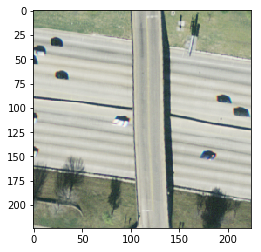

In [21]:
ds = dataset['val']
ix = random.randint(0, len(ds)-1)
img, label = ds[ix]
pred = net(img.unsqueeze(0).to(device)).squeeze()
pred_lab = torch.argmax(pred).item()
plt.imshow(img.numpy().transpose((1,2,0)))
img.shape, cats[label], cats[pred_lab]

# Convert model

In [22]:
import torch

dummy_input = torch.randn((1,3,224,224))
torch.onnx.export(net.cpu(), dummy_input, "test.onnx")

In [23]:
import onnx

# Load the ONNX model
model = onnx.load("test.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)